# Project 2

## Setup

In [204]:
#!pip install tensorflow
#!pip install scikeras
#!pip install scikeras[tensorflow]      # gpu compute platform
#!pip install scikeras[tensorflow-cpu]  # cpu 
#!pip install xgboost

In [206]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import metrics
import tensorflow.keras as keras
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

In [4]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,prepaid,default
0,709.0,201703,9,204702,NaN,12,1,P,84,26,...,51300,F117Q1000376,N,360,2,Other sellers,Other servicers,NaN,0,1
1,649.0,201703,9,203202,33124.0,0,1,P,52,22,...,33100,F117Q1000418,C,180,2,Other sellers,Other servicers,NaN,1,0
2,747.0,201703,9,203702,41180.0,0,1,I,43,20,...,63100,F117Q1000479,N,240,2,Other sellers,Other servicers,NaN,1,0
3,711.0,201703,9,204702,20260.0,0,1,I,80,21,...,55800,F117Q1000523,P,360,2,Other sellers,Other servicers,NaN,1,0
4,751.0,201703,N,204702,NaN,35,1,P,95,24,...,75900,F117Q1000719,P,360,1,Other sellers,ARVESTCENTRALMTGECO,NaN,1,0


# Introduction

The objective of this assignment is to analyze loan-level credit performance data provided by Freddie Mac as a Data Scientist Consultant. The goal is to develop a classification model that predicts whether a client will default on fully amortizing fixed-rate Single-Family mortgages purchased or guaranteed by the company. The analysis aims to assist investors in building more accurate credit performance models to support ongoing risk-sharing initiatives highlighted by regulators, particularly the Federal Housing Finance Agency.

The dataset provided by Freddie Mac contains loan-level credit performance data for fully amortizing fixed-rate Single-Family mortgages. 

Loan Characteristics: The dataset includes various characteristics of loans, such as credit scores (FICO), loan-to-value ratio (LTV), debt-to-income ratio (DTI), original unpaid balance (orig_upb), original loan term (orig_loan_term), property type (prod_type), loan purpose (loan_purpose), occupancy status (occpy_sts), first-time homebuyer flag (flag_fthb), mortgage insurance percentage (mi_pct), number of units (cnt_units), and more. These attributes provide insights into the financial situation of borrowers and the terms of their loans.

Default Information: The dataset contains a target variable indicating whether a loan defaulted or not (0 for no default, 1 for default). This is the variable of interest for predictive modeling and risk assessment purposes.



Before performing any data analysis on the data, we first need to look into the nature of the data and the variables. 

# Exploratory Data Analysis and Feature Engineering

Before performing any data analysis on the data, we first need to look into the nature of the data and the variables. 

When dealing with any data analysis task, we first need to define the nature of the problem. To do that, we first need to understand the nature of the data. The follwoing commands are useful for understanding the basic structure of the data (i.e type of values, distribution, null and outliers, etc.)

We use simple functions to understand the nature of the data-

In [5]:
#d.describe()
#print(d.isnull().sum())
#d.info()

Since our objective is to predict the probability of default in a given loan application, we need to evaluate the distribution of the defaults (0= no, 1=yes) in the given dataset.

We calculate the percentage of defaults in the given dataset-

In [6]:
default_counts = d['default'].value_counts()
default_ratio = (default_counts[1] / default_counts[0])*100
default_ratio

1.8861625771991322

Thus, there are only 1.886% of default cases in the total loan applications in the given dataset.

Let's further analyse the structure of rest of the variables in the dataset.

We begin by filtering variables that we deem is most impactful in default cases. Then we remove outliers/extreme values/indicators of missing values from the dataset. Then we remove any null values. This step is important as it helps cleaning any unnecessary information that may taint the model predictions, thus, increases the accuracy and readibility of the data.

In [7]:
filtered_columns= ['fico','flag_fthb','mi_pct','cnt_units','occpy_sts','cltv','dti','orig_upb','ltv','int_rt','prod_type','loan_purpose','orig_loan_term','cnt_borr','default']
df= d[filtered_columns]
df.loc[df['cltv'] == 999, 'cltv'] = pd.NA
df.loc[df['dti'] == 999, 'cltv'] = pd.NA
df1= df.dropna()
df1.head()

,fico,flag_fthb,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,int_rt,prod_type,loan_purpose,orig_loan_term,cnt_borr,default
0,709.0,9,12,1,P,84.0,26,310000,84,3.625,FRM,N,360,2,1
1,649.0,9,0,1,P,52.0,22,190000,52,2.875,FRM,C,180,2,0
2,747.0,9,0,1,I,43.0,20,61000,43,4.000,FRM,N,240,2,0
3,711.0,9,0,1,I,80.0,21,90000,80,4.625,FRM,P,360,2,0
4,751.0,N,35,1,P,95.0,24,112000,95,4.250,FRM,P,360,1,0


Visual representations of the data help in conveying information that may otherwise be difficult to notice. Therefore, we first compute a simple pairs-plot of the dataset to understand the interelation of the variables.

In [8]:
quant_columns= ['fico','cltv','dti','orig_upb','ltv','int_rt','orig_loan_term','default']
pair_df= df1[quant_columns]

Here, we will colour-code the dataset to highlight the default cases. The blue dots refer to normal cases, whereas the orange dots show loan cases that defaulted. 

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


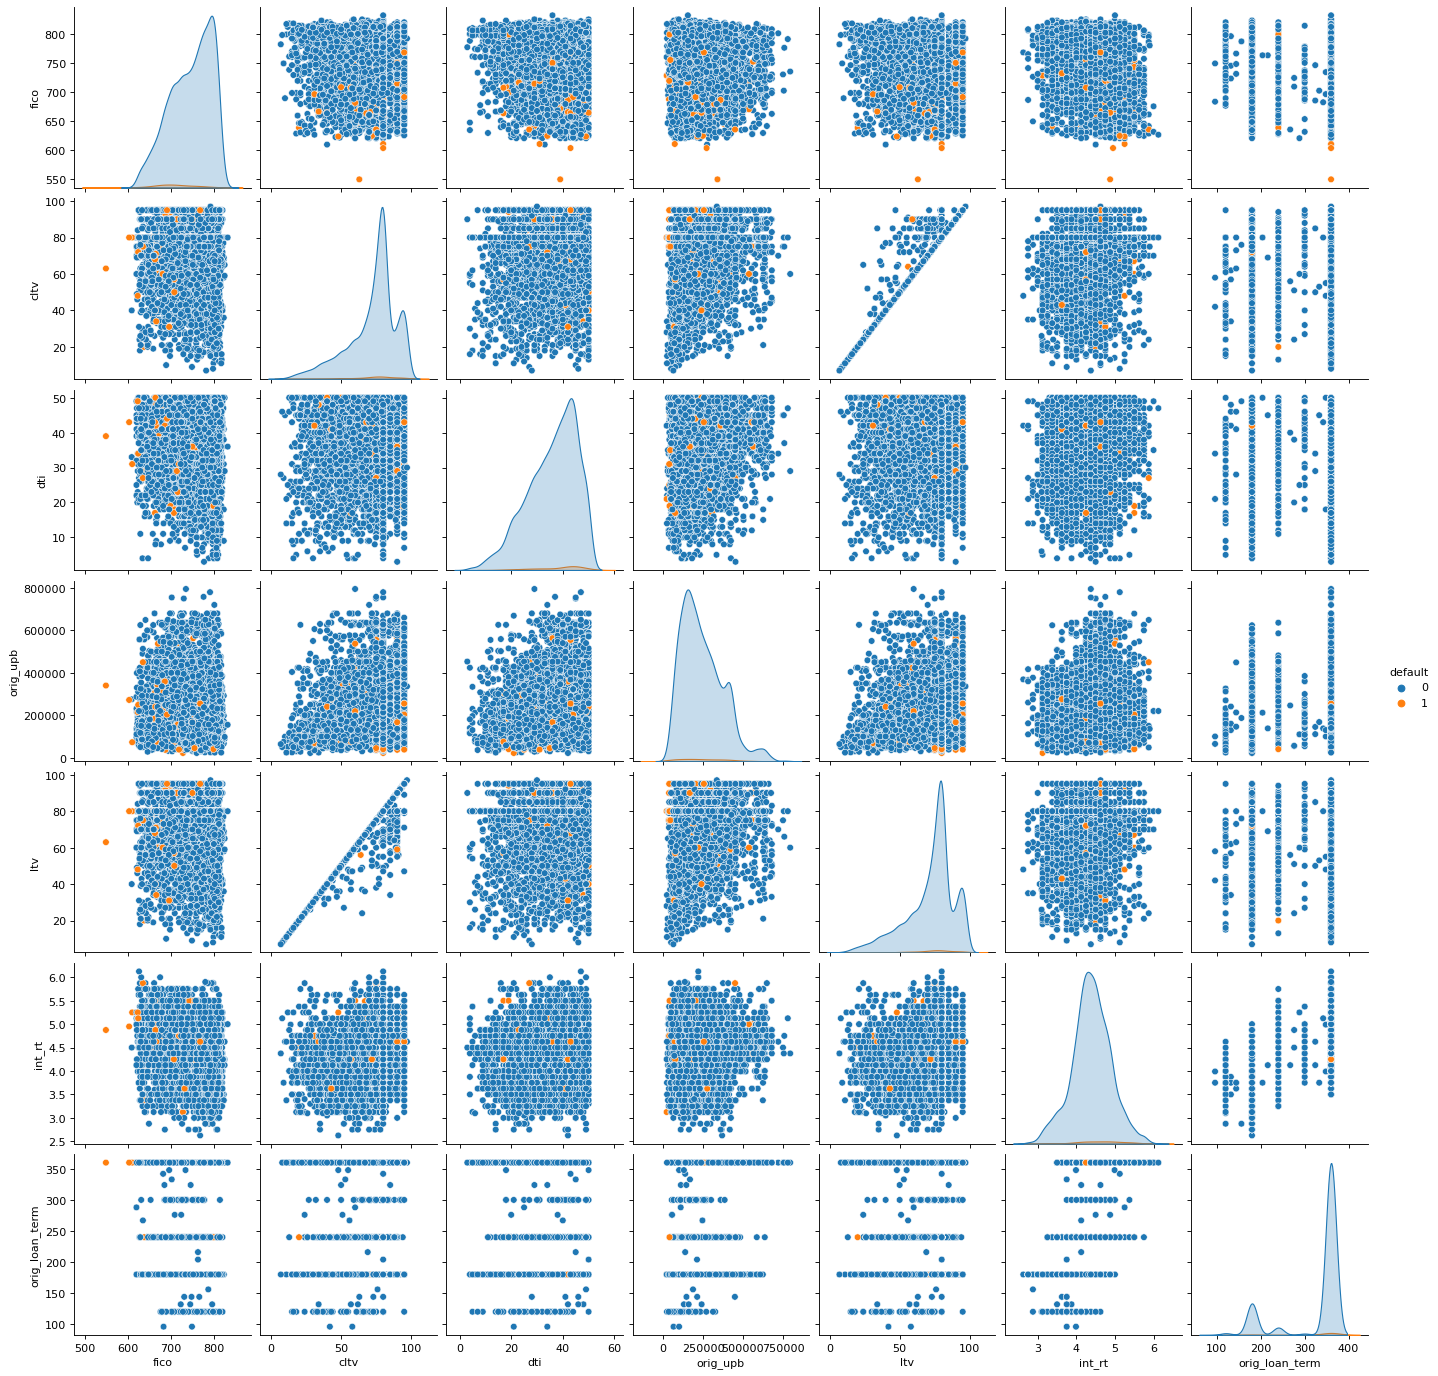

In [9]:
sns.pairplot(pair_df, hue='default')

Based on the pairs-plot and the 'default_ratio' we computed earlier, it is evident that the data has highly imbalanced values. We need to further investigate the nature of this imbalance with selected variables.

One of the major variables when considering loan applications is the 'fico' which is a summarised statistic score conveying the applicant's creditworthiness of the application based ona comprehensive evaluation of their wealth, assests, liabilities, loans, etc. Another variable is the 'debt-to-income-ratio', which basically informs the bank how much debt the applicant has is in comparision to their income.

Therefore, we investigate the defaults based on these two variables.

<Axes: xlabel='fico', ylabel='dti'>

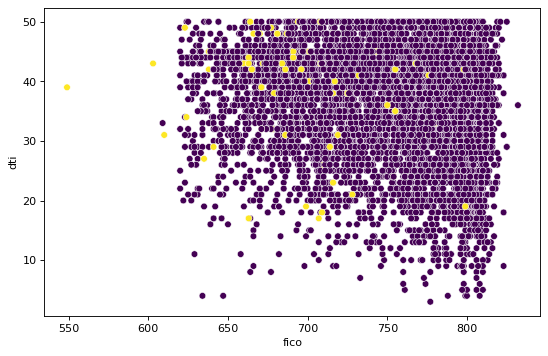

In [10]:
#plt.scatter(df1['fico'], df1['dti'], c=df1['default'], cmap='viridis') 
sns.scatterplot(x= df1['fico'], y= df1['dti'], c= df1['default'], cmap='viridis' )

Another variable to consider is the 'cltv' which informs the combined value of the loan.

<Axes: xlabel='fico', ylabel='cltv'>

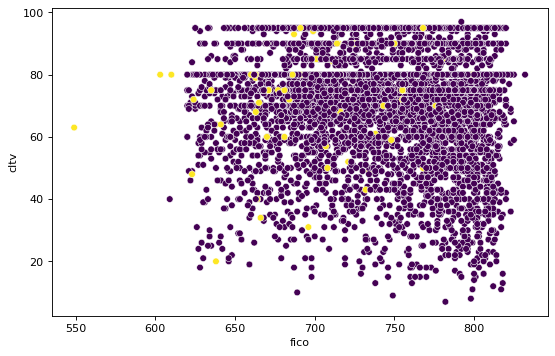

In [11]:
sns.scatterplot(x=df1['fico'], y=df1['cltv'], c=df1['default'], cmap='viridis')

The 'fico' and 'dti' explain the credit habits of the applicant, while the 'cltv' indicates the nature of the loan. In both the case, we can see that there is no discernable pattern of default cases that can help us set thresholds to eliminate certain candidates, or the informs us about the nature of default cases.

The following bar chart represents the frequency distribution of the defaults and non-default cases.

<BarContainer object of 2 artists>

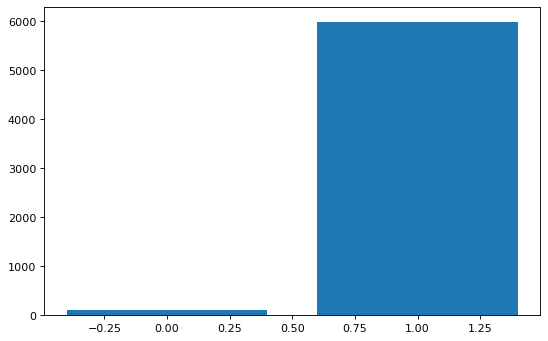

In [12]:
plt.bar(df1['default'].unique(), df1['default'].value_counts())

Therefore, as evidenced by the scatterplot and the bar plot, the data highly imbalanced, i.e. the data is unevenly distributed in the classes. Here, the output classes are default=0 or no default=1 and there are only 1.88% of non-defaults present in the data, which makes the data imbalanced.

Thus, Imbalanced datasets are those where there is a severe skew in the class distribution, such as 1:100 or 1:1000 examples in the minority class to the majority class.

This bias in the training dataset can influence many machine learning algorithms, leading the model to ignore the minority class entirely. This is a problem as it is typically the minority class on which predictions are most important. Here, our minority class are the defaults, which may be small in comparision, however, are extremely detrimental to the financial insitution.

One approach to addressing the problem of class imbalance is to randomly resample the training dataset. The two main approaches to randomly resampling an imbalanced dataset are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling or upsampling.

In real world scenario, the number of default cases will more often than not, be less in number- considering the rigorous risk analysis finacial institutions perform on each loan applicant. Therefore, the imbalance in data was not due to underepresentation of default cases due to an underlining bias. Therefore, using undersampling seems counter-intuitive.

Thus, we perform upsampling, which is to duplicate the instances of minority cases.

In [13]:
from sklearn.utils import resample
features=['fico','cltv','dti','ltv','default']
dff= df1[features]

# Separate majority and minority classes
majority_class = dff[dff['default'] == 0]
minority_class = dff[dff['default'] == 1]

# Upsample minority class
minority_upsampled = resample(minority_class, 
                               replace=True,     # sample with replacement
                               n_samples=len(majority_class),    # to match majority class
                               random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
upsampled_df = pd.concat([majority_class, minority_upsampled])

# Check the class distribution after upsampling
upsampled_df['default'].value_counts()

0    5989
1    5989
Name: default, dtype: int64

Here, we can see that the sample data has equal number of defaults, as compared to 1.88% in the original dataset.

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


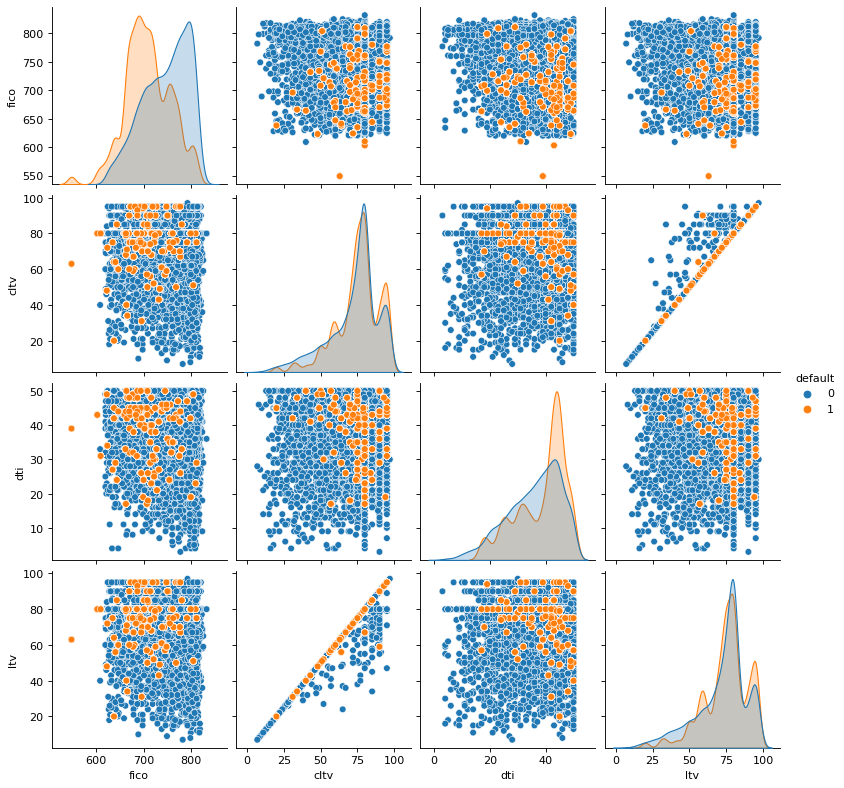

In [14]:
sns.pairplot(upsampled_df, hue= 'default')

The pairplot chart also reveals that the default cases are much better represented now.

This implies that we can now perform test-train split on the sampled data.

In [15]:
#Splitting into train and test data sets

data_x, data_y = upsampled_df.drop(['default'], axis=1), upsampled_df['default']

print(data_x.shape)
print(data_y.shape)

# Before Splitting the data set 
print("Class Distribution (%)")
# get our null accuracy rate 
data_y.value_counts(normalize=True)*100

(11978, 4)
(11978,)
Class Distribution (%)


0    50.0
1    50.0
Name: default, dtype: float64

The response dataset (data_y) has equal presentation of majority and n=minority class.

In [16]:
from sklearn.model_selection import train_test_split

# Initialize LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column in data_x
for column in data_x.columns:
    if data_x[column].dtype == 'object':  # Check if the column contains string values
        data_x[column] = label_encoder.fit_transform(data_x[column])

features = list(data_x.columns)

X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y.values, stratify = data_y, 
                                                    test_size = 0.1, random_state=42)


# TO CHECK: The same proportion is satisfied for both train and test data sets 
print(pd.Series(y_train).value_counts(normalize=True)*100)
print(pd.Series(y_test).value_counts(normalize=True)*100)

0    50.0
1    50.0
dtype: float64
1    50.0
0    50.0
dtype: float64


The same representation is carried in the test and train data.

Therefore, now we can proceed to model formulations. 

# Model Fitting and Tuning

We need to perform binary classification on the data in order to predict the probability of default. Therefore we need to select an appropriate model for the task. 

#### Baseline Model: Logistic Regression

Various machine learning models can help in classification tasks, but the most simple model for bianry classification is the logistic regression model. 

We shall use the logistic regression model as the baseline model to evaluate the subsequent model(s). 

In [17]:
from sklearn.linear_model import LogisticRegression

# Fit the logistic regression model
logfit = LogisticRegression(random_state=42, penalty="none").fit(X_train, y_train)
print(logfit.score(X_test, y_test))

0.6352253756260434


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.63 is the accuracy of the logistic regression model on the test data. This is moderate level of accuracy, hence is a suitable baseline model.

In [18]:
# For class probabilities
print(logfit.predict_proba(X_test))

[[0.23874107 0.76125893]
 [0.51871689 0.48128311]
 [0.31017773 0.68982227]
 ...
 [0.49630221 0.50369779]
 [0.41181436 0.58818564]
 [0.56106766 0.43893234]]


### Model Metrics

Different model metrics are used to evaluate the accuracy and efficiency of the model. We select the most appropriate model, based on these metrics. 

The ROC and AUC curve metrics are computed for logistic regression model- 

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

#In terms of testing data 
print("Accuracy of the fitted model:", accuracy_score(y_test, logfit.predict(X_test)))
print("AUC of the fitted model:", roc_auc_score(y_test, logfit.predict_proba(X_test)[:,1]))

Accuracy of the fitted model: 0.6352253756260434
AUC of the fitted model: 0.7121830764128305


In [20]:
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps

In [107]:
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline 

#Pre-processing Pipeline
log_pipe = Pipeline([
    ("scaler", StandardScaler()), #applies standard scaling to the input features
    ("model", LogisticRegression(random_state=42, penalty="l2", C=1.0))]) 
#fits a logistic regression model with L2 regularization with default strength (c=1)

log_pipe.fit(X_train, y_train) #applying pipeline to training data

# use the classifier to predict the validation set    
predictions = log_pipe.predict(X_test)
print(predictions)

[1 0 1 ... 1 1 0]


The 'predictions' gives us the predicted values for the test data.
In this case, the defaults/non-defaults. 

Now, before further analysing the nature and predictions based on different model metrics, we define another model for the classification task. 

Evaluating multiple models helps us select the 'Best Possible' model for the given data and problem at hand. 

### Artificial neural network (ANN) model

In [114]:
# Define the model architecture
model = Sequential()
# First layers: 16 neurons/perceptrons that takes the input and uses 'sigmoid' activation function.
model.add(Dense(units = 64 , activation = 'relu',))
# Second layer: 1 neuron/perceptron that takes the input from the 1st layers and gives output as 0 or 1.Activation used is 'Hard Sigmoid'
model.add(Dense(32, activation = 'relu')) #Rectified Linear Unit activation function 
model.add(Dense(1, activation = 'sigmoid')) #Sigmoid binary classification

# compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


Here is a breakdown of the ANN model- 

* A Sequential Model  indicates a linear stack of layers


* The model consists of densely connected layers, also known as fully connected layers. Each neuron in a layer is connected to every neuron in the previous and next layers.


* The Rectified Linear Unit (ReLU) activation function is  used in hidden layers of neural networks to introduce non-linearity. 


* The sigmoid activation function is  used for binary classification tasks as it squashes the output values between 0 and 1, representing probabilities of belonging to the positive class.


* The output layer consists of a single neuron with a sigmoid activation function. It produces a single output value representing the probability of the input belonging to the positive class (defaults) in binary classification tasks.

We now need to implement the model on training dataset. However in order to get the best classification model, we use GridSearchCV() function to get the best possible estimators for the model fitting. 

In [181]:
# Define the Keras model
def create_model(epochs=100, batch_size=32):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=X_train1.shape[1]))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss=binary_crossentropy, optimizer=Adam(), metrics=['accuracy'])
      # Set epochs and batch_size based on function arguments (optional)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)  

    return model

param_grid = {
  'epochs': [50, 100, 150],
  'batch_size': [32, 64, 128]
}

grid_search = GridSearchCV(estimator=KerasClassifier(model, verbose=0), 
                           param_grid=param_grid, cv=5)  # 5-fold cross-validation

In [182]:
grid_search.fit(X_test, y_test,verbose=0) #Output prevented from printing in report for readability reasons

GridSearchCV(cv=5,
             estimator=KerasClassifier(model=<Sequential name=sequential_258, built=True>, verbose=0),
             param_grid={'batch_size': [32, 64, 128], 'epochs': [50, 100, 150]})

Based on the GridsearchCV(), these are the best parameters for the ANN model. 
Please note that ince we have not set a random seed, it is likely that the parameters may slightly change for each time the GridSearchCV() is called.

In [183]:
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best hyperparameters:", best_parameters)
print("\nBest model:", best_model)

Best hyperparameters: {'batch_size': 32, 'epochs': 150}

Best model: KerasClassifier(
	model=<Sequential name=sequential_258, built=True>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=150
	class_weight=None
)


In [184]:
# Train the model
model.fit(X_train, y_train, epochs=150, batch_size=32,verbose=0, validation_data=(X_test, y_test))

In [185]:
# Test, Loss and accuracy
loss_and_metrics = model.evaluate(X_test, y_test)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6463 - loss: 0.6109 
Loss =  0.600575864315033
Accuracy =  0.6527546048164368


The accuracy of the ANN model (0.6527) is slightly higher than that of the Logistic Regression model (0.62). 

In [186]:
y_pred_nnn= model.predict(X_test)
print(y_pred_nnn)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
[[0.65562373]
 [0.5570197 ]
 [0.76001513]
 ...
 [0.50902784]
 [0.47039148]
 [0.42510724]]


Thus we have the predictive probability of belonging to the non-default class. 
It should be noted that .predict() function returns the probabilities of class for the ANN model (keras), whereas in logistic regression model, it return the predicted outcomes. (For probabilities we need to use predict_proba() function for LR model)

The accuracy of the ANN model is adequate, however, we can improve it by integrating the ANN model with a StandardScaler pipeline. By incorporating StandardScaler() into the pipeline before feeding the data into the neural network model, we ensure that the data is properly transformed and standardized, which can lead to improved model performance.

In [180]:
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the Keras model
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier wrapper
keras_wrapper = KerasClassifier(
    model=create_model,
    batch_size=32,
    epochs=10,
    verbose=0
)

# Define the pipeline
nnn_pipe = Pipeline([
    ("scaler", StandardScaler()),  # Step 1: StandardScaler
    ("model", keras_wrapper)  # Step 2: Neural Network Model
])

# Fit the pipeline
nnn_pipe.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KerasClassifier(batch_size=32, epochs=10, model=<function create_model at 0x7f64e082c670>, verbose=0))])

In [187]:
from sklearn.metrics import accuracy_score
accuracy = nnn_pipe.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.7545909849749582


Thus, using the StandardScaler() has significantly improved our model accuracy, from 0.65 to 0.75. 
75% accuracy is quite standard and acceptable for making inferences. 

In [190]:
y_pred_nnnp= nnn_pipe.predict(X_test)
print(y_pred_nnnp)

[1 1 1 ... 1 0 0]


Thus, we have the predicted values of the defaults using the Artificial Neural Network standardsised model with 75% accuracy. 

### Model Accuracy checks 

Computing a confusion matrix useful for evaluating the performance of a classification model. 
A confusion matrix provides a detailed breakdown of the model's predictions compared to the true labels in a tabular format. Each cell of the matrix represents the count of instances where the model predicted a certain class (rows) compared to the actual class (columns).

Furthermore, with a confusion matrix, we can identify the types of errors made by the model, such as false positives (Type I errors) and false negatives (Type II errors). This information can be crucial for understanding the limitations of the model and guiding further improvements.

True Positive (TP): These are instances where the model correctly identifies positive cases.

False Positive (FP): These are instances where the model incorrectly identifies negative cases as positive. (Type I error)

False Negative (FN): These are instances where the model incorrectly identifies positive cases as negative. (Type II error)

True Negative (TN): These are instances where the model correctly identifies negative cases. 

In [194]:
# get the confusion matrix as a numpy array
confmatLR = confusion_matrix(y_true = y_test, y_pred=predictions)

# Output for the confusion matrix for LogisticRegression model  
confmatLR

array([[392, 207],
       [230, 369]])

Therefore, for logistic regression model, 392 is the True Positive(TP), 207 are the False Positives(FP), 230 are the False Negatives(FN) and 369 are the True Negatves(TN)

In [192]:
# Create the confusion matrix
confmatANN = confusion_matrix(y_true=y_test, y_pred=y_pred_nnnp)
print("Confusion Matrix:")
print(confmatANN)

Confusion Matrix:
[[435 164]
 [130 469]]


Therefore, for the standardised NNN model, 435 is the True Positive(TP), 164 are the False Positives(FP), 130 are the False Negatives(FN) and 469 are the True Negatves(TN)

Now, we define these helper functions to facilitate easy and quick metrics computations based on the confusion matrix:

In [196]:
def metrics(confmat):
    FP_i = [0,1]
    TN_i = [0,0]
    TP_i = [1,1]
    FN_i = [1,0]

    # Extracting the quantities from the confusion matrix 
    FP = confmat[0,1]
    TN = confmat[0,0]
    TP = confmat[1,1]
    FN = confmat[1,0]

    #Calculation of FPR, Recall, Precision and F1 Score
    # FPR
    FPR = (FP)/(FP+TN)
    # Recall
    Recall = (TP)/(TP+FN)
    # Precision
    Precision = (TP)/(FP+TP)
    # F1 Score
    F1 = 2 * (Precision * Recall)/(Precision + Recall)

    print('False Positive Rate (FPR): '+ '%.3f' % FPR)
    print('Recall: '+ '%.3f' % Recall)
    print('Precision: '+ '%.3f' % Precision)
    print('F1 Score: '+ '%.3f' % F1)
    
#ROC curve drawing by using the helper function
def plot_roc_curve(roc):
    """
    Plots the ROC curve from a DataFrame.
    
    Parameters:
    - roc: DataFrame containing 'false positive rate', 'true positive rate', and 'threshold' columns.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(roc['false positive rate'], roc['true positive rate'], label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # adding a 45-degree dashed line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

We now compute the False positive rate, Recall, Precision and F1 score of the  models using the helper functions defined above. 

In [197]:
metrics(confmatLR)

False Positive Rate (FPR): 0.346
Recall: 0.616
Precision: 0.641
F1 Score: 0.628


In [198]:
metrics(confmatANN)

False Positive Rate (FPR): 0.274
Recall: 0.783
Precision: 0.741
F1 Score: 0.761


Thus, based on the computed metrics, the Artificial Neural Network (ANN) model outperforms the Logistic Regression model across all metrics:

* The ANN has a lower False Positive Rate (FPR), indicating fewer incorrect positive predictions.
* It achieves a higher Recall, capturing a larger proportion of actual positive instances.
* The ANN exhibits higher Precision, making fewer false positive predictions.
* It achieves a higher F1 Score, reflecting a better balance between precision and recall.

We also considered the XGB_classifier, which is a tree classification model.

The accuracy of the model was computed to be- 98.33%

And the classification metrics for this model were as follows- 

                precision    recall  f1-score   support

           0       1.00      0.97      0.98       599
           1       0.97      1.00      0.98       599

    accuracy                           0.98        1198
 
    macro avg       0.98      0.98     0.98        1198
   
    weighted avg    0.98      0.98     0.98        1198

However, such high values of accuracy (more than 90%) can also indicate overfitting. Therefore, we select the Neural Network Model for the task. 

##### ROC (Receiver Operating Characteristic) and AUC (Area Under the Curve) 

AUC represents the area under the ROC curve, with higher values indicating better discrimination between positive and negative instances. Comparing the ROC curves and AUC scores will provide insights into the discriminative performance of the logistic regression and ANN models.

In [199]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, precision_recall_curve

roc_calc = roc_curve(y_true = y_test, y_score = predictions)
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

# Values for ROC based on different threshold 
print(roc)

#Print the related AUC value 
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions))

   false positive rate  true positive rate  threshold
0             0.000000            0.000000        2.0
1             0.345576            0.616027        1.0
2             1.000000            1.000000        0.0
AUC value: 0.6352253756260434


In the LogisticRegression case, the AUC value is 0.635, suggesting moderate discriminative performance of the model.

In [202]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, precision_recall_curve

roc_calc_nnn = roc_curve(y_true = y_test, y_score = y_pred_nnnp)
roc_nnn = pd.DataFrame(
    data = np.c_[roc_calc_nnn],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

# Values for ROC based on different threshold 
print(roc_nnn)

#Print the related AUC value 
print("AUC value:", roc_auc_score(y_true = y_test1, y_score = y_pred_nnnp))

   false positive rate  true positive rate  threshold
0              0.00000            0.000000        2.0
1              0.27379            0.782972        1.0
2              1.00000            1.000000        0.0
AUC value: 0.7545909849749582


In the standardised ANN case, the AUC value is 0.755, indicating reasonably good discriminatory performance of the model.

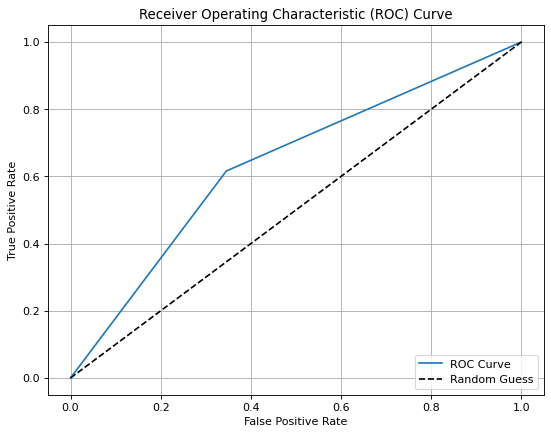

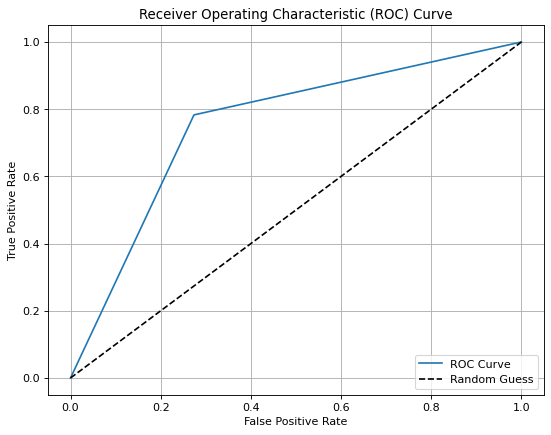

In [203]:
plot_roc_curve(roc)
plot_roc_curve(roc_nnn)

The ROC curve for LR model is moderately good. But the standardised ANN ROC curve is better because it has higher area under the curve. 
Visually representing the ROC curve also reveals that the standardised ANN model performs better than the baseline LOgisticRegression model. 

# Discussion & Conclusions

The final model for the classification task is the standardised Artificial Neural Neral Network model, dur to following advantages-

* It presents a 75% accuracy for the predictions for default cases. 

* It is based on three main variables- 'fico', 'cltv' and 'dti', these variables best represented the defaults, since they are representative of both- the applicants' credit behaviour (fico, dti), whereas the nature of the loan (cltv). Furthermore, these three statistics are most widely used in loan applications. Therefore the model has better application scope.  

* The model is a good represntative of the data as it used upsampling technique. 

* The false positive rates are considerably low (), indicating that the chances of miinterpreting a default case for non-default case is quite low. 

The task of classifying defaults in a loan application/finacial application is extremely crucial to finacial institutions. Therefore, a 75% accuracy is not completely adequate. Therefore, multiple other types of standardisers can be used to improve model efficiancy.

Future enhancements could focus on exploring alternative architectures, fine-tuning hyperparameters, and incorporating additional data sources to further enhance predictive accuracy and robustness.

Overall, the ANN model represents a significant step forward in predicting default cases, offering valuable insights and predictive capabilities that can support informed decision-making and drive positive outcomes in finacial risk prediction.


# References

*Include references if any*

In [211]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2Final.ipynb

[NbConvertApp] Converting notebook project2Final.ipynb to pdf
[NbConvertApp] Writing 2076585 bytes to project2Final.pdf


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2a9ec8d-a343-4210-b36b-f9db26268fc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>